## Task 8.1 HD Interpolated Policy Gradient for Pendulum

In [1]:
import gym
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [2]:
env = gym.make("Pendulum-v1")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
state_size = env.observation_space.shape
action_size = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
critic_learning_rate = 0.002
actor_learning_rate = 0.001
epochs = 10
batch_size = 128
buffer_capacity = 20000 
epsilon = 0.2
gamma = 0.993
lmbda = 0.7
critic_optimizer = tf.keras.optimizers.Adam(critic_learning_rate)
actor_optimizer = tf.keras.optimizers.Adam(actor_learning_rate)
baseline_optimizer = tf.keras.optimizers.Adam(actor_learning_rate)

### Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, buffer_capacity, batch_size):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer = deque(maxlen=self.buffer_capacity)

    def __len__(self):
        return len(self.buffer)

    def record(self, experience: list):
        self.buffer.append(experience)

    def sample(self):
        valid_batch_size = min(len(self.buffer), self.batch_size)
        mini_batch = random.sample(self.buffer, valid_batch_size)

        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        for i in range(valid_batch_size):
            state_batch.append(mini_batch[i][0])
            action_batch.append(mini_batch[i][1])
            reward_batch.append(mini_batch[i][2])
            next_state_batch.append(mini_batch[i][3])
            done_batch.append(mini_batch[i][4])
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch


    def get_samples(self, n_samples=None):
        if n_samples is None or n_samples > len(self.buffer):
            n_samples = len(self.buffer)

        s_batch = []
        a_batch = []
        r_batch = []
        ns_batch = []
        d_batch = []
        for i in range(n_samples):
            s_batch.append(self.buffer[i][0])
            a_batch.append(self.buffer[i][1])
            r_batch.append(self.buffer[i][2])
            ns_batch.append(self.buffer[i][3])
            d_batch.append(self.buffer[i][4])

        return s_batch, a_batch, r_batch, ns_batch, d_batch

    def clear(self):
        self.buffer.clear()

### Actor

In [5]:
class MLPActor:
    def __init__(self, state_size, action_size, upper_bound,
                 lr, epsilon):
        self.state_size = state_size 
        self.action_size = action_size  
        self.lr = lr
        self.epsilon = epsilon              
        self.upper_bound = upper_bound
        self.model = self._build_net(trainable=True)
        self.optimizer = tf.keras.optimizers.Adam(self.lr)
        logstd = tf.Variable(np.zeros(shape=self.action_size, dtype=np.float32))
        self.model.logstd = logstd
        self.model.trainable_variables.append(logstd)

    def _build_net(self, trainable=True):
        state_size = env.observation_space.shape
        action_size = env.action_space.shape[0]
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

        inputs = tf.keras.layers.Input(shape = state_size)
        out = layers.Dense(256, activation="relu")(inputs)
        out = layers.Dense(256, activation="relu")(out)
        outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
        outputs = outputs * upper_bound
        model = tf.keras.Model(inputs, outputs)
        model.summary()
        tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
        return model

    def __call__(self, state):
        mean = tf.squeeze(self.model(state))
        logstd = tf.Variable(np.zeros(shape=env.action_space.shape[0], dtype=np.float32))
        std = tf.squeeze(tf.exp(logstd))
        return mean, std

    def train(self, states, actions, advantages, old_pi, critic, b, s_batch):
        with tf.GradientTape() as tape:
            # on-policy ppo loss
            mean = tf.squeeze(self.model(states))
            std = tf.squeeze(tf.exp(self.model.logstd))
            pi = tfp.distributions.Normal(mean, std)
            ratio_np = np.ones((128,1,3))
            ratio = tf.convert_to_tensor(ratio_np, dtype=tf.float32)
            adv_stack = tf.stack([advantages for _ in range(1)], axis=1)
            surr = ratio * adv_stack
            clipped_surr = tf.clip_by_value(ratio, 1. - self.epsilon, 1. + self.epsilon) * adv_stack
            ppo_loss = tf.reduce_mean(tf.minimum(surr, clipped_surr))

            # off-policy ppo loss
            # action estimate
            a_batch = tf.squeeze(self.model(s_batch)) 
            # q estimates
            q_values = critic.model([s_batch, a_batch])     
            sum_q_values = tf.reduce_sum(tf.reduce_mean(q_values))
            off_loss = (b / len(s_batch)) * sum_q_values
            actor_loss = -tf.reduce_sum(ppo_loss + off_loss)
            actor_wts = self.model.trainable_variables

        
        actor_grad = tape.gradient(actor_loss, actor_wts)
        self.optimizer.apply_gradients(zip(actor_grad, actor_wts))
        return actor_loss.numpy()

### Critic

In [6]:
class MLPCritic:
    def __init__(self, state_size, action_size, learning_rate,
                 gamma):
      self.state_size = state_size    # shape: (w, h, c)
      self.action_size = action_size  # shape: (n, )
      self.lr = learning_rate
      self.gamma = gamma          # discount factor

      # create NN model
      self.model = self._build_net()
      self.optimizer = tf.keras.optimizers.Adam(self.lr)

    def _build_net(self):
      state_input = layers.Input(shape=(self.state_size))
      state_out = layers.Dense(16, activation="relu")(state_input)
      state_out = layers.Dense(32, activation="relu")(state_out)

      action_input = layers.Input(shape=(self.action_size))
      action_out = layers.Dense(32, activation="relu")(action_input)

      concat = layers.Concatenate()([state_out, action_out])

      out = layers.Dense(256, activation="relu")(concat)
      out = layers.Dense(256, activation="relu")(out)
      outputs = layers.Dense(1)(out)

      model = tf.keras.Model([state_input, action_input], outputs)
      model.summary()
      tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
      return model

    def train(self, state_batch, action_batch, y):
        with tf.GradientTape() as tape:
            critic_wts = self.model.trainable_variables
            critic_value = self.model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value))
        # outside gradient tape
        critic_grad = tape.gradient(critic_loss, critic_wts)
        self.optimizer.apply_gradients(zip(critic_grad, critic_wts))
        return critic_loss.numpy()

### Variance Reducer Network

In [7]:
class VarianceReducerNet:
    def __init__(self, state_size, action_size, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.model = self._build_net()
        self.optimizer = tf.keras.optimizers.Adam(self.lr)

    def _build_net(self):
        state_size = env.observation_space.shape
        action_size = env.action_space.shape[0]
        lr = 0.0002
        optimizer = tf.keras.optimizers.Adam(lr)
        state_input = tf.keras.layers.Input(shape=state_size)
        f = tf.keras.layers.Dense(128, activation="relu", trainable=True)(state_input)

        out = tf.keras.layers.Dense(128, activation="relu", trainable=True)(f)
        out = tf.keras.layers.Dense(64, activation="relu", trainable=True)(out)
        out = tf.keras.layers.Dense(32, activation="relu", trainable=True)(out)
        net_out = tf.keras.layers.Dense(1, trainable=True)(out)

        # Outputs single value for a given state = V(s)
        model = tf.keras.Model(inputs=state_input, outputs=net_out)
        model.summary()
        tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)    
        return model

    def train(self, states, returns):
        with tf.GradientTape() as tape:
            critic_wts = self.model.trainable_variables
            critic_values = self.model(states)
            critic_loss = tf.math.reduce_mean(tf.square(returns - critic_values))

        critic_grad = tape.gradient(critic_loss, critic_wts)
        self.optimizer.apply_gradients(zip(critic_grad, critic_wts))
        return critic_loss.numpy()

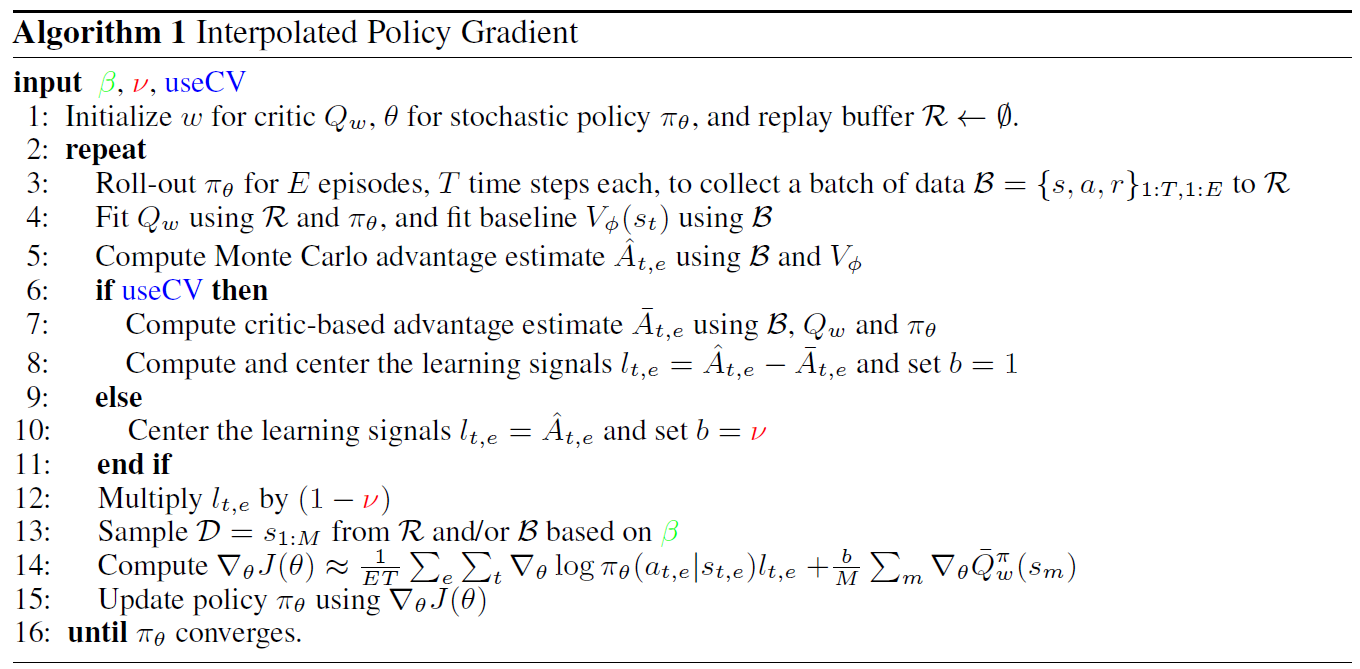

### Agent

In [8]:
class InterpolatingAgent:
    def __init__(self):
      self.buffer = ReplayBuffer(50000, 64)
      self.learning_rate = 0.0002
      self.actor = MLPActor(state_size, action_size, upper_bound, self.learning_rate, epsilon)
      self.critic = MLPCritic(state_size, action_size, self.learning_rate, gamma)

      self.target_actor = MLPActor(state_size, action_size, upper_bound, self.learning_rate, epsilon)
      self.target_critic = MLPCritic(state_size, action_size, self.learning_rate, gamma)

      self.baseline = VarianceReducerNet(state_size, action_size, self.learning_rate)
      self.time_steps = 0

      # Making the weights equal initially
      self.target_actor.model.set_weights(self.actor.model.get_weights())
      self.target_critic.model.set_weights(self.critic.model.get_weights())

    def policy(self, state, deterministic=False):
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        # mean, std = self.actor(tf_state)
        mean, std = self.actor(state)

        if deterministic:
            action = mean
        else:
            pi = tfp.distributions.Normal(mean, std)
            action = pi.sample()
        #action = mean + np.random.uniform(-self.upper_bound, self.upper_bound, size=mean.shape) * std
        action = tf.clip_by_value(action, lower_bound, upper_bound)
        return action.numpy()

    def run(self):
      state = env.reset()
      state = np.asarray(state, dtype=np.float32)

      val_scores = []
      best_score = -np.inf
      s_scores = []
      ep_lens = [] 
      ep_scores = []
      episode_num = 100
      avg_rewards = []

      
      for episode in range(episode_num):
        state = env.reset()
        episodic_reward = 0
        s_score = 0
        states, next_states, actions, rewards, dones = [], [], [], [], []
        ep_reward_list = []

        while True:
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = self.policy(tf_prev_state)
            
            next_state, reward, done, info = env.step([action])

            next_state = np.asarray(next_state, dtype=np.float32)
            states.append(state)
            next_states.append(next_state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)

            self.buffer.record((state, action, reward, next_state, done))
            episodic_reward += reward

            if done:
              s_score += episodic_reward
              state, done, score = env.reset(), False, 0
              state = np.asarray(state, dtype=np.float32)
              break

            state = next_state
            ep_reward_list.append(episodic_reward)

        
        if len(ep_reward_list) > 10:
          avg_reward = np.mean(ep_reward_list[-10:])
          print("Episode Avg Reward for last {} cohort of episodes is ==> {}".format(episode, avg_reward))
          avg_rewards.append(avg_reward)

        actor_loss, critic_loss = self.train(states, actions, rewards, next_states, dones)
      
            

      env.close()
      return avg_rewards

    def compute_advantage(self, r_batch, s_batch, ns_batch, d_batch):
        gamma = 0.99
        lmbda = 0.7
        s_values = tf.squeeze(self.baseline.model(s_batch)) # input: tensor
        ns_values = tf.squeeze(self.baseline.model(ns_batch))

        returns = []
        # generalized advantage estimate
        gae = 0     
        for i in reversed(range(len(r_batch))):
            delta = r_batch[i] + gamma * ns_batch[i] * (1 - d_batch[i]) - s_batch[i]
            gae = delta + gamma * lmbda * (1 - d_batch[i]) * gae
            returns.insert(0, gae + s_batch[i])

        returns = np.array(returns)
        adv = returns - s_batch.numpy()
        adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
        return adv, returns

    def compute_targets(self, r_batch, ns_batch, d_batch):
        mean = self.actor.model(ns_batch)
        target_critic = self.critic.model([ns_batch, mean])
        y = r_batch + gamma * (1 - d_batch) * target_critic
        return y

    def compute_adv_bar(self, s_batch, a_batch):
        mean = self.actor.model(s_batch)
        x = tf.squeeze(a_batch) - tf.squeeze(mean)
        y = tf.squeeze(self.critic.model([s_batch, mean]))
        adv_bar = y * x
        return adv_bar

    # implements on-policy & off-policy training
    def train(self, states, actions, rewards, next_states, dones):
        n_split = len(rewards) // batch_size
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)

        advantages, returns = self.compute_advantage(rewards, states, next_states, dones)

        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        # if use control variate: Compute critic-based advantages and compute learning signal
        use_CV = False
        v = 0.2
        if use_CV:
            # compute critic-based advantage
            adv_bar = self.compute_adv_bar(states, actions)
            ls = advantages - adv_bar
            b = 1
        else:
            ls = advantages
            b = v

        ls *= (1 - v)

        indexes = np.arange(n_split, dtype=int)

        # current policy
        mean, std = self.actor(states)
        pi = tfp.distributions.Normal(mean, std)

        a_loss_list = []
        c_loss_list = []
        np.random.shuffle(indexes)
        for _ in range(epochs):
            # increment global step counter
            self.time_steps += 1

            # sample a minibatch from replay buffer
            s_batch, a_batch, r_batch, ns_batch, d_batch = self.buffer.sample()

            s_batch = tf.convert_to_tensor(s_batch, dtype=tf.float32)
            a_batch = tf.convert_to_tensor(a_batch, dtype=tf.float32)
            r_batch = tf.convert_to_tensor(r_batch, dtype=tf.float32)
            ns_batch = tf.convert_to_tensor(ns_batch, dtype=tf.float32)
            d_batch = tf.convert_to_tensor(d_batch, dtype=tf.float32)

            for i in indexes:

                s_split = tf.gather(states, indices=np.arange(i * batch_size, (i+1) * batch_size), axis=0)
                a_split = tf.gather(actions, indices=np.arange(i * batch_size, (i+1) * batch_size), axis=0)
                ls_split = tf.gather(ls, indices=np.arange(i * batch_size, (i+1) * batch_size), axis=0)
                t_split = tf.gather(returns, indices=np.arange(i * batch_size, (i+1) * batch_size), axis=0)
                old_pi = pi[i * batch_size: (i+1) * batch_size]

                # update actor
                a_loss = self.actor.train(s_split, a_split, ls_split,
                                          old_pi, self.critic, b, s_batch)
                a_loss_list.append(a_loss)
                # update variance reducer net
                v_loss = self.baseline.train(s_split, t_split)

            # update critic
            y = self.compute_targets(r_batch, ns_batch, d_batch)
            c_loss = self.critic.train(s_batch, a_batch, y)
            c_loss_list.append(c_loss)

        return np.mean(a_loss_list), np.mean(c_loss_list)
      

In [9]:
agent = InterpolatingAgent()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
 tf.math.multiply (TFOpLambd  (None, 1)                0         
 a)                                                              
                                                                 
Total params: 67,073
Trainable params: 67,073
Non-trainable params: 0
_________________________________________________________

In [10]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [11]:
avg_rewards = agent.run()

Episode Avg Reward for last 0 cohort of episodes is ==> -855.1421743812103
Episode Avg Reward for last 1 cohort of episodes is ==> -1018.5048074897513
Episode Avg Reward for last 2 cohort of episodes is ==> -1600.9782499571122
Episode Avg Reward for last 3 cohort of episodes is ==> -865.6325651437122
Episode Avg Reward for last 4 cohort of episodes is ==> -965.9588528696413
Episode Avg Reward for last 5 cohort of episodes is ==> -1373.6405046683794
Episode Avg Reward for last 6 cohort of episodes is ==> -836.2063444760888
Episode Avg Reward for last 7 cohort of episodes is ==> -1658.8102413507852
Episode Avg Reward for last 8 cohort of episodes is ==> -1399.2943440501822
Episode Avg Reward for last 9 cohort of episodes is ==> -957.0158459965571
Episode Avg Reward for last 10 cohort of episodes is ==> -1308.0995084615279
Episode Avg Reward for last 11 cohort of episodes is ==> -1066.1233066972006
Episode Avg Reward for last 12 cohort of episodes is ==> -1636.4649388751845
Episode Avg Re

### Average Reward

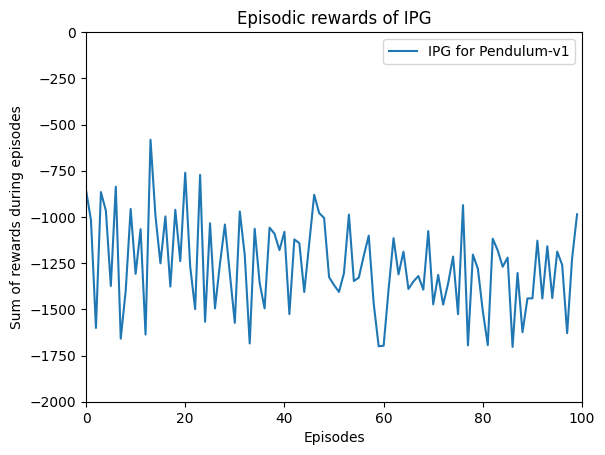

In [13]:
plt.plot(np.arange(100), avg_rewards, label='IPG for Pendulum-v1')
plt.ylim(-2000, 0)
plt.xlim(0, 100)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episodes')
plt.title('Episodic rewards of IPG')
plt.legend()